<a href="https://colab.research.google.com/github/ayush9h/PyTorch-DeepLearning/blob/main/Meta_Parameters_Activations%2C_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install scikit-learn

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

import scipy.stats as stats
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0

data['boolQuality'][data['quality']>5] = 1


/tmp/ipython-input-1666556559.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/tmp/ipython-input-1666556559.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [8]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()

labels = labels[:,None]

In [10]:
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

from torch.utils.data import DataLoader

train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [11]:
class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    self.input = nn.Linear(11,16)

    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    self.output = nn.Linear(32,1)

    self.actfun = actfun

  def forward(self,x):

    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

In [12]:
numepochs = 1000
import numpy as np
def trainTheModel():

  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.001)

  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  for epochi in range(numepochs):

    winenet.train()

    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    trainAcc.append( np.mean(batchAcc) )

    losses[epochi] = np.mean(batchLoss)

    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )


  return trainAcc,testAcc,losses


In [13]:
activation_funs = [ 'ReLU', 'ReLU6', 'LeakyReLU' ]

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
  winenet = ANNwine(actfun)
  trainByAct[:,ai],testByAct[:,ai],losses = trainTheModel()


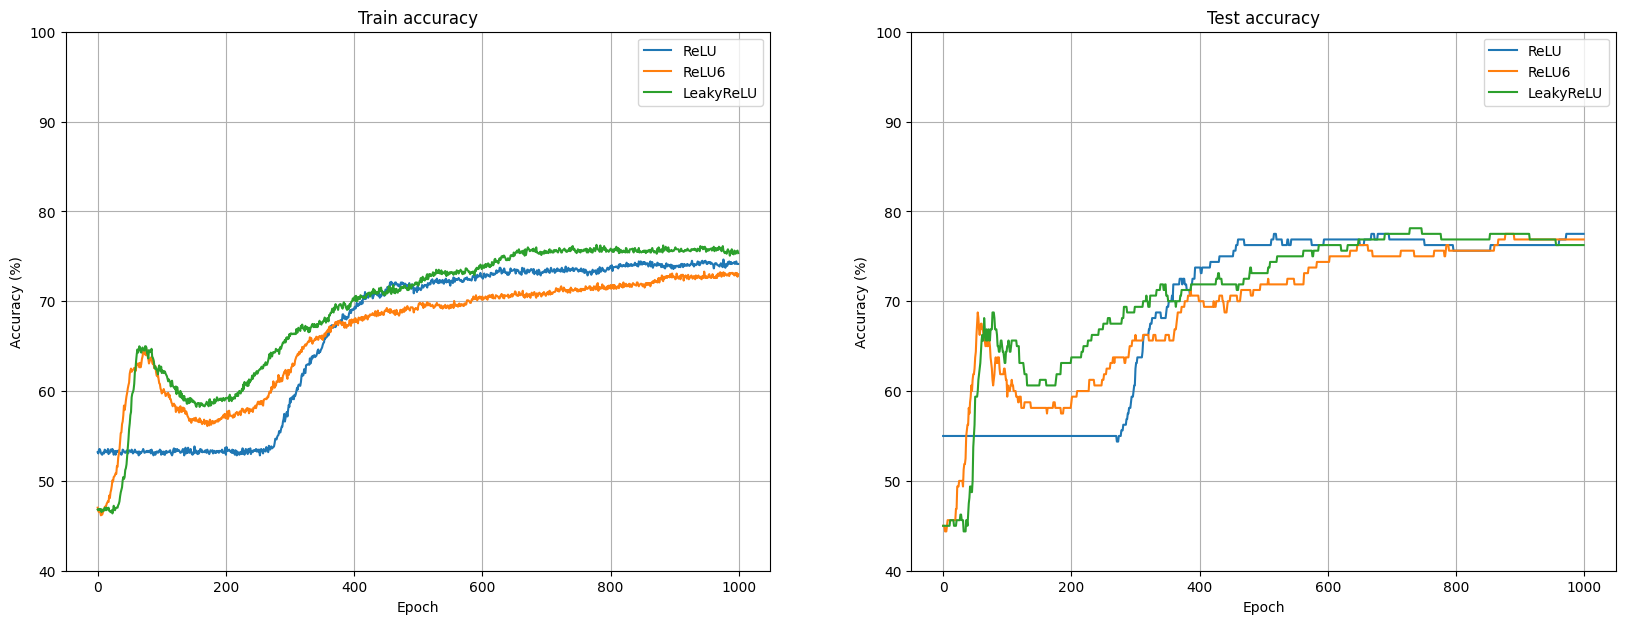

In [17]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([40,100])
  ax[i].grid()

In [18]:
# Kullback - Leibler Divergence(KL distance)
# Distance between two probability distributions

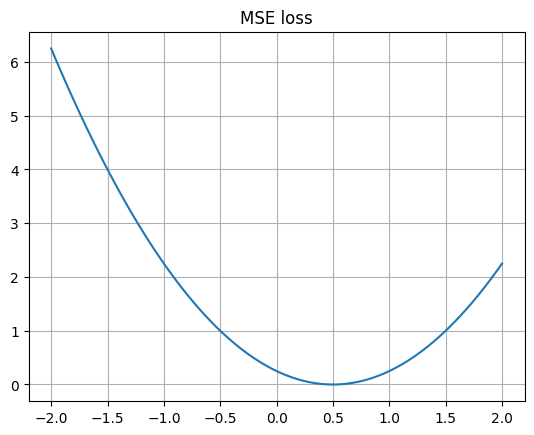

In [19]:
lossfunMse = nn.MSELoss()
yHat = torch.linspace(-2,2,101)
y = torch.tensor(0.5)

L = np.zeros(101)
for i, yy in enumerate(yHat):
  L[i] = lossfunMse(yy,y)


plt.plot(yHat,L)
plt.title('MSE loss')
plt.grid()


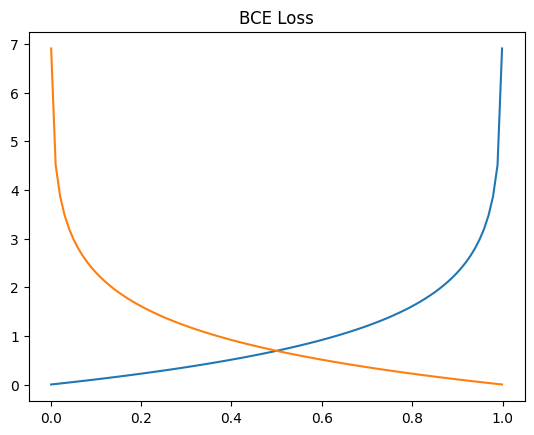

In [22]:
lossfunBCE = nn.BCELoss()

yHat = torch.linspace(.001, .999, 101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

L = np.zeros((101,2))

for i, yy in enumerate(yHat):
  L[i, 0] = lossfunBCE(yy, y1)
  L[i, 1] = lossfunBCE(yy, y2)

plt.plot(yHat, L)
plt.title("BCE Loss")
plt.show()

In [24]:
# Custom Loss function
class custLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x,y):
    loss = torch.abs(x - y)
    return loss


lfun = custLoss()
lfun(torch.tensor(5.),torch.tensor(2.))

tensor(3.)

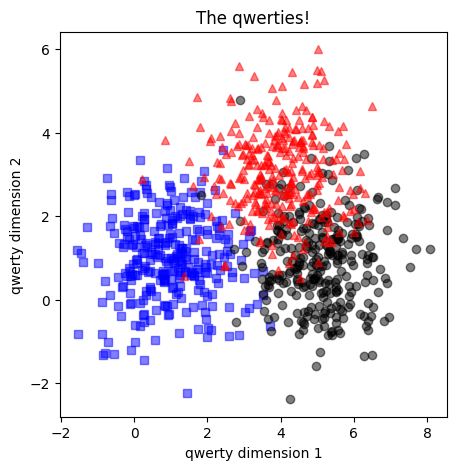

In [25]:
nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

data_np = np.hstack((a,b,c)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [27]:

from torch.utils.data import TensorDataset
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [28]:
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.input = nn.Linear(2,8)
      self.fc1 = nn.Linear(8,8)
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  net = qwertyNet()
  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(net.parameters(),lr=.01,momentum=momentum)

  return net,lossfun,optimizer

In [29]:
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [30]:
numepochs = 50


def function2trainTheModel(momentum):

  net,lossfun,optimizer = createTheQwertyNet(momentum)

  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )
    trainAcc.append( np.mean(batchAcc) )

    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)


    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  return trainAcc,testAcc,losses,net


In [31]:
momenta = [0,.5,.9,.95,.999]

results = np.zeros((numepochs,len(momenta),3))

for idx,mom in enumerate(momenta):
  trainAcc,testAcc,losses,net = function2trainTheModel(mom)
  results[:,idx,0] = losses
  results[:,idx,1] = trainAcc
  results[:,idx,2] = testAcc


/tmp/ipython-input-719038137.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  results[:,idx,0] = losses
/tmp/ipython-input-719038137.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  results[:,idx,2] = testAcc


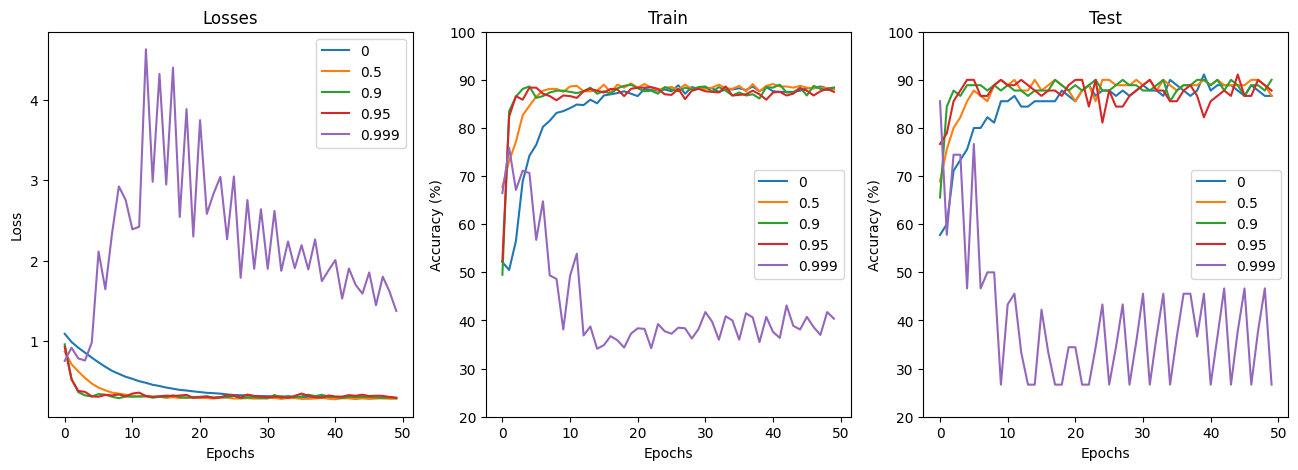

In [32]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()
